<a href="https://colab.research.google.com/github/Brice-D/Computer-Vision/blob/master/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Standrard libraries
import matplotlib.pyplot as plt
import cv2 
import numpy as np
import os
from PIL import Image 

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Input, Dropout
from keras.models import Model, Sequential
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

Using TensorFlow backend.


In [2]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
zip_path = "/content/drive/My Drive/Project/5857_1166105_bundle_archive.zip"
!cp "{zip_path}" /tmp
%cd /tmp
!unzip -q 5857_1166105_bundle_archive.zip

/tmp


# **plot function**

In [4]:
def plot_model_history(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [5]:
resnet_weights = '/content/drive/My Drive/Project/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
resnet_model = ResNet50(include_top=False, weights=resnet_weights, input_shape=(100, 100, 3), pooling='max')

In [6]:
def model(train_base_layers, num_classes=131, optimizer=Adam(learning_rate=1e-4)):
  resnet_model.trainable=train_base_layers

  # add my own hidden layers 
  base_model = Sequential()
  base_model.add(resnet_model)
  base_model.add(Dense(512, activation='relu'))
  base_model.add(Dropout(0.25))
  base_model.add(Dense(256, activation = 'relu'))
  base_model.add(Dropout(0.25))

  #output layer
  base_model.add(Dense(num_classes, activation='softmax'))

  # print all layers of my_model() 
  base_model.summary()

  #learning_rate=1e-5
  base_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

  return base_model



In [7]:
def print_prediction(prediction):
  print('loss: ', prediction[0])
  print('accuracy: ', prediction[1])   

In [8]:
train_data_dir = '/tmp/fruits-360/Training'
test_data_dir  = '/tmp/fruits-360/Test'

input_shape = (100, 100)
batch = 128

**Data Augmentation**

- **rescale**: target values of the data between 0 and 1 by scaling with 1. / 255
- **shear_range**: produce a slightly deformed image
- **zoom_range**: for magnification and demagnification of the images, the value have to be in the range [0.0, 1.0]
- **horizontal_flip**: to flip the images horizontall
- **validation_split**: validation_data = 20% * train_data

In [ ]:
# Data augmentation
train_datagenerator = ImageDataGenerator(rescale= 1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, validation_split=0.2)
test_datagenerator  = ImageDataGenerator(rescale=1./255)

# Training dataset have to be spillted in 2 part:
# 80% Dataset for training and 20% for validation
training_data = train_datagenerator.flow_from_directory(train_data_dir, target_size=input_shape, class_mode='categorical', batch_size=batch, subset='training')
validation_data = train_datagenerator.flow_from_directory(train_data_dir, target_size=input_shape, class_mode='categorical', batch_size=batch, subset='validation')

# Test Dataset have to be use to test the model after training
test_data = test_datagenerator.flow_from_directory(test_data_dir, target_size=input_shape, shuffle = False, class_mode='categorical', batch_size=batch)

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [ ]:
print(len(training_data), len(validation_data), len(test_data))

424 106 178


## **First test without tuning**

In [ ]:
first_model = model(train_base_layers=False)

#train the model
history = first_model.fit_generator(training_data, epochs=10, steps_per_epoch=len(training_data),
                                  validation_data=validation_data, validation_steps=len(validation_data), verbose=1)


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_13 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 131)               33667     
Total params: 24,801,795
Trainable params: 1,214,083
Non-trainable params: 23,587,712
__________________________________

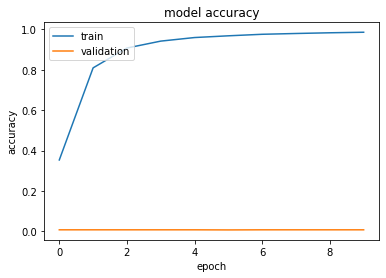

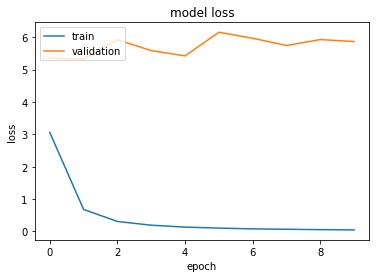

In [ ]:
plot_model_history(history)

In [ ]:
# evaluation
score_1 = first_model.evaluate_generator(test_data, steps=len(test_data), verbose=1)
print_prediction(score_1)

178/178 [==============================] - 29s 165ms/step
loss:  5.392179489135742
accuracy:  0.007184414658695459


In [ ]:
# prediction
y_true = test_generator.classes
predictions = first_model.predict_generator(test_data, steps=len(test_data), verbose=1)
y_predic = np.argmax(predictions, axis=1)

178/178 [==============================] - 31s 174ms/step


In [ ]:
# print predictions
print(y_predic.shape)
wrong_ind = np.where(np.equal(y_predic, y_true) == False)[0]

print('whe have', wrong_ind.shape[0], 'index')

(22688,)
whe have 22525 index


## **second model with some tuning**

In [ ]:
model_2 = model(train_base_layers=True)

history_2 = model_2.fit_generator(training_data, epochs=10, steps_per_epoch=len(training_data),
                                  validation_data=validation_data, validation_steps=len(validation_data), verbose=1)


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_19 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 131)               33667     
Total params: 24,801,795
Trainable params: 24,748,675
Non-trainable params: 53,120
_____________________________________

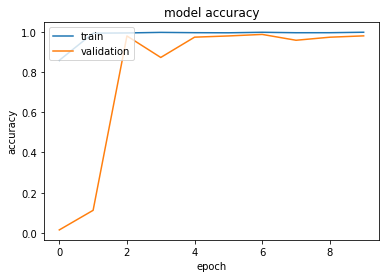

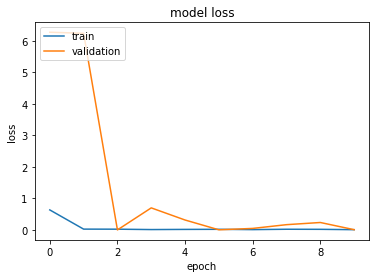

In [ ]:
plot_model_history(history)

In [ ]:
# score
score_2 = model_2.evaluate_generator(test_data, steps=len(test_data), verbose=1)

178/178 [==============================] - 29s 165ms/step


In [ ]:
print_prediction(score_2)

loss:  0.0
accuracy:  0.9843529462814331


In [ ]:
# prediction
y_true = test_generator.classes
predictions = model_2.predict_generator(test_data, steps=len(test_data), verbose=1)
y_predic = np.argmax(predictions, axis=1)

178/178 [==============================] - 30s 167ms/step


In [ ]:
# print predictions
print(y_predic.shape)
wrong_ind = np.where(np.equal(y_predic, y_true) == False)[0]

print('whe have', wrong_ind.shape[0], 'wrong index')

(22688,)
whe have 355 wrong index


In [ ]:
model_2.save('/content/drive/My Drive/Project/fine_tuned_1')

## **third model**

In [ ]:
# Data augmentation
train_generator = ImageDataGenerator(rescale= 1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# generate data from directory
train_3 = train_generator.flow_from_directory(train_data_dir, target_size=input_shape, class_mode='categorical', batch_size=batch)

# testdata are splited in 2 part
# 80% for test and 20% for validation
validation_data_3 = test_generator.flow_from_directory(test_data_dir, target_size=input_shape, class_mode='categorical', batch_size=batch, subset='validation')
test_data_3 = test_generator.flow_from_directory(test_data_dir, target_size=input_shape, shuffle = False, class_mode='categorical', batch_size=batch, subset='training')

#training
model_3 = model(train_base_layers=True)

history_3 = model_3.fit_generator(train_3, epochs=10, steps_per_epoch=len(train_3),
                                  validation_data=validation_data_3, validation_steps=len(validation_data_3), verbose=1)



Found 67692 images belonging to 131 classes.
Found 4481 images belonging to 131 classes.
Found 18207 images belonging to 131 classes.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_7 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 131)            

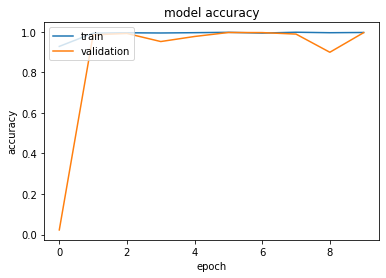

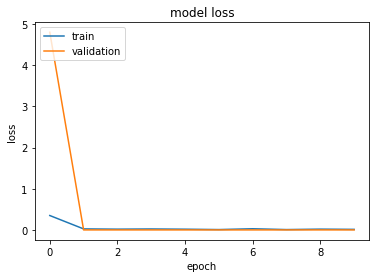

In [ ]:
plot_model_history(history_3)

In [ ]:
model_3.save('/content/drive/My Drive/Project/fine_tuned_model_3')


In [ ]:
score_3 = model_3.evaluate_generator(test_data_3, steps=len(test_data_3), verbose=1)

143/143 [==============================] - 15s 105ms/step


In [ ]:
print_prediction(score_3)

loss:  7.906072823971044e-06
accuracy:  0.9898390769958496


In [ ]:
# prediction
y_true = test_data_3.classes
predictions = model_3.predict_generator(test_data_3, steps=len(test_data_3), verbose=1)
y_predic = np.argmax(predictions, axis=1)

143/143 [==============================] - 16s 109ms/step


In [ ]:
# print predictions
print(y_predic.shape)
wrong_ind = np.where(np.equal(y_predic, y_true) == False)[0]

print('whe have', wrong_ind.shape[0], 'wrong index')

(18207,)
whe have 185 wrong index


## **fourth model**

In [ ]:
model_4 = model(train_base_layers=True)

history_4 = model_4.fit_generator(train_3, epochs=30,
                                  steps_per_epoch=len(train_3),
                                  validation_data=validation_data_3, 
                                  validation_steps=len(validation_data_3),
                                  verbose=1)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_10 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 131)               33667     
Total params: 24,801,795
Trainable params: 24,748,675
Non-trainable params: 53,120
_____________________________________

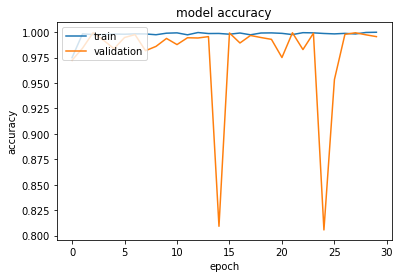

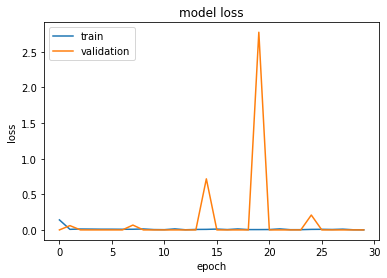

In [ ]:
plot_model_history(history_4)

In [ ]:
score_4 = model_4.evaluate_generator(test_data_3, steps=len(test_data_3), verbose=1)


143/143 [==============================] - 15s 105ms/step


In [ ]:
print_prediction(score_4)

loss:  0.0
accuracy:  0.985005795955658


In [ ]:
# prediction
y_true = test_data_3.classes
predictions = model_4.predict_generator(test_data_3, steps=len(test_data_3), verbose=1)
y_predic = np.argmax(predictions, axis=1)

143/143 [==============================] - 16s 111ms/step


In [ ]:
# print predictions
print(y_predic.shape)
wrong_ind = np.where(np.equal(y_predic, y_true) == False)[0]

print('whe have', wrong_ind.shape[0], 'wrong index')

(18207,)
whe have 273 wrong index


## **fifth model**

In [ ]:
optimizer = Adam(learning_rate=1e-5)
model_5 = model(train_base_layers=True, optimizer=optimizer)

history_4 = model_5.fit_generator(train_3, epochs=10,
                                  steps_per_epoch=len(train_3),
                                  validation_data=validation_data_3, 
                                  validation_steps=len(validation_data_3),
                                  verbose=1)


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_13 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 131)               33667     
Total params: 24,801,795
Trainable params: 24,748,675
Non-trainable params: 53,120
_____________________________________

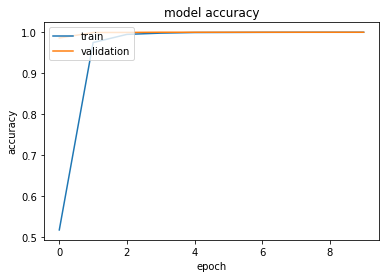

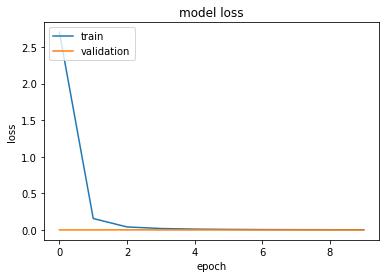

In [ ]:
plot_model_history(history_4)

In [ ]:
score_5 = model_5.evaluate_generator(test_data_3, steps=len(test_data_3), verbose=1)


143/143 [==============================] - 15s 105ms/step


In [ ]:
print_prediction(score_5)

loss:  6.191186230353196e-07
accuracy:  0.9873125553131104


In [ ]:
# prediction
y_true = test_data_3.classes
predictions = model_5.predict_generator(test_data_3, steps=len(test_data_3), verbose=1)
y_predic = np.argmax(predictions, axis=1)

143/143 [==============================] - 16s 109ms/step


In [ ]:
# print predictions
print(y_predic.shape)
wrong_ind = np.where(np.equal(y_predic, y_true) == False)[0]

print('whe have', wrong_ind.shape[0], 'wrong index')

(18207,)
whe have 231 wrong index


In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix

# print('Confusion Matrix')
# print(confusion_matrix(y_true, y_predic))
# print('Classification Report')
# print(classification_report(y_true, y_predic, target_names=target_names))